In [22]:
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
from seaborn import heatmap
from sklearn.decomposition import PCA


pd.set_option('display.max_columns', 40)
plt.rcParams['figure.figsize'] = 12,7
plt.rcParams['figure.dpi'] = 100


df: pd.DataFrame = pd.read_csv("Life Expectancy Data.csv")
df_copy = df.copy()


# Formatting DataFrame for further analysis
stripped_columns = []

for col_num, col_name in enumerate(df.columns):
    stripped_columns.append(col_name.strip(' '))
    
df.columns = stripped_columns

df = df.sort_values(by=['Country', 'Year'])
df = df.reset_index(drop=True)


**<h1>**As the data represents a bunch of time serieses across different countries it is reasonable to assume that we might better split this task into 2 tasks:**</h1>**

**<h3>**1. Regression anaylysis for each year<br>2. Multivariate time series analysis for each country**</h3>**


**<h5>**It is also reasonable to do the regression analysis for each year as the bare minimum condition of having atleast 5-6 training example per feature is satisfied (183/193 data points per 20 features)**</h5>**


In [23]:
regression_df = df.copy()
regression_df = regression_df.sort_values(by='Year')
regression_df = regression_df.reset_index(drop=True)

regression_df['Status'] = regression_df['Status'].replace({
    "Developed": 1,
    "Developing": 0,
})


C:\Users\user\AppData\Local\Temp\ipykernel_10604\1529690317.py:5: FutureWarning: Downcasting behavior in `replace` is deprecated and will be removed in a future version. To retain the old behavior, explicitly call `result.infer_objects(copy=False)`. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  regression_df['Status'] = regression_df['Status'].replace({


**<h2>**Handling missing data**</h2>**

In [26]:
columns_with_null_values = regression_df.columns[(regression_df.isnull().sum()>0).values]
column_and_indeces = {}

for column in columns_with_null_values:
    column_and_indeces[column] = regression_df[regression_df[column].isnull()==True].index

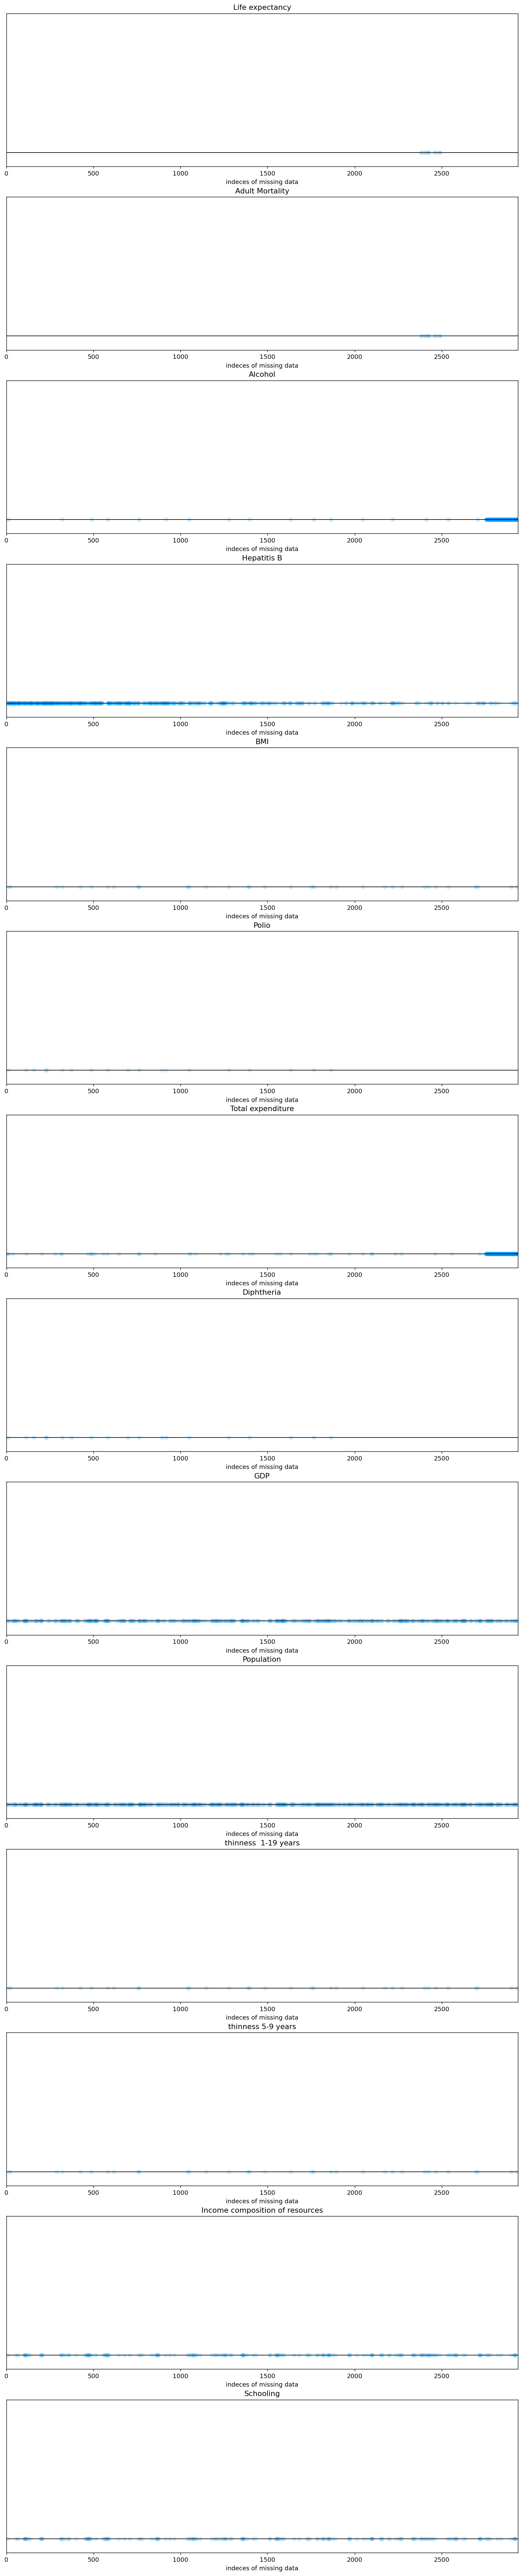

In [27]:
fig, axes = plt.subplots(len(column_and_indeces), figsize = (15, 75), dpi = 130)


for index, (key, values) in enumerate(column_and_indeces.items()):
    axes[index].hlines(y=0, xmin=0, xmax=2938, color='black', linewidth=1)

    axes[index].scatter(values, [0] * len(values), color=(0,0.6,1), alpha=0.15)

    axes[index].set_yticks([])
    axes[index].set_xlim(0, 2938)
    axes[index].set_ylim(-1, 10)

    axes[index].set_title(key)
    axes[index].set_xlabel("indeces of missing data")


In [8]:
metrics_with_weird_behavior = [
    'Alcohol',
    'BMI',
    'Polio',
    'Total expenditure',
    'Diphtheria',
    'thinness  1-19 years',
    'thinness 5-9 years',
]

countries_total_missing_values = {}


for metric in metrics_with_weird_behavior:
    df = pd.DataFrame(regression_df[regression_df[metric].isnull()==True]['Country'].value_counts())

    for item in df.iterrows():
        if item[0] in countries_total_missing_values.keys():
            countries_total_missing_values[item[0]]+=item[1].values[0]
        else:
            countries_total_missing_values[item[0]] = item[1].values[0]


pd.DataFrame(
                {
                    'Country': countries_total_missing_values.keys(),
                    'Total_Null': countries_total_missing_values.values()
                }             
             ).sort_values(by='Total_Null', ascending=False)[:15]

,Country,Total_Null
0,South Sudan,99
62,Sudan,50
67,Somalia,17
50,Democratic People's Republic of Korea,17
1,Montenegro,15
42,Timor-Leste,6
171,Iraq,5
178,Monaco,3
179,San Marino,3
124,Argentina,2


**<h3>**We can see, that South Sudan and Sudan miss lots of data, so it'd be reasonable to drop the data instances from South Sudan & Sudan**</h3>**

In [9]:
regression_df = regression_df[regression_df['Country']!='South Sudan']
regression_df = regression_df[regression_df['Country']!='Sudan']

regression_df.reset_index(drop=True, inplace=True)


**<h3>**As the other indices of missing data are distributed rather randomly we can omit the step with analyzing them as it is pretty safe to say that the reason for the absence of some metrics is completely random**</h3>**

In [10]:
regression_df_wo_null = regression_df.copy()
regression_df_wo_null = regression_df_wo_null.dropna()

<Axes: >

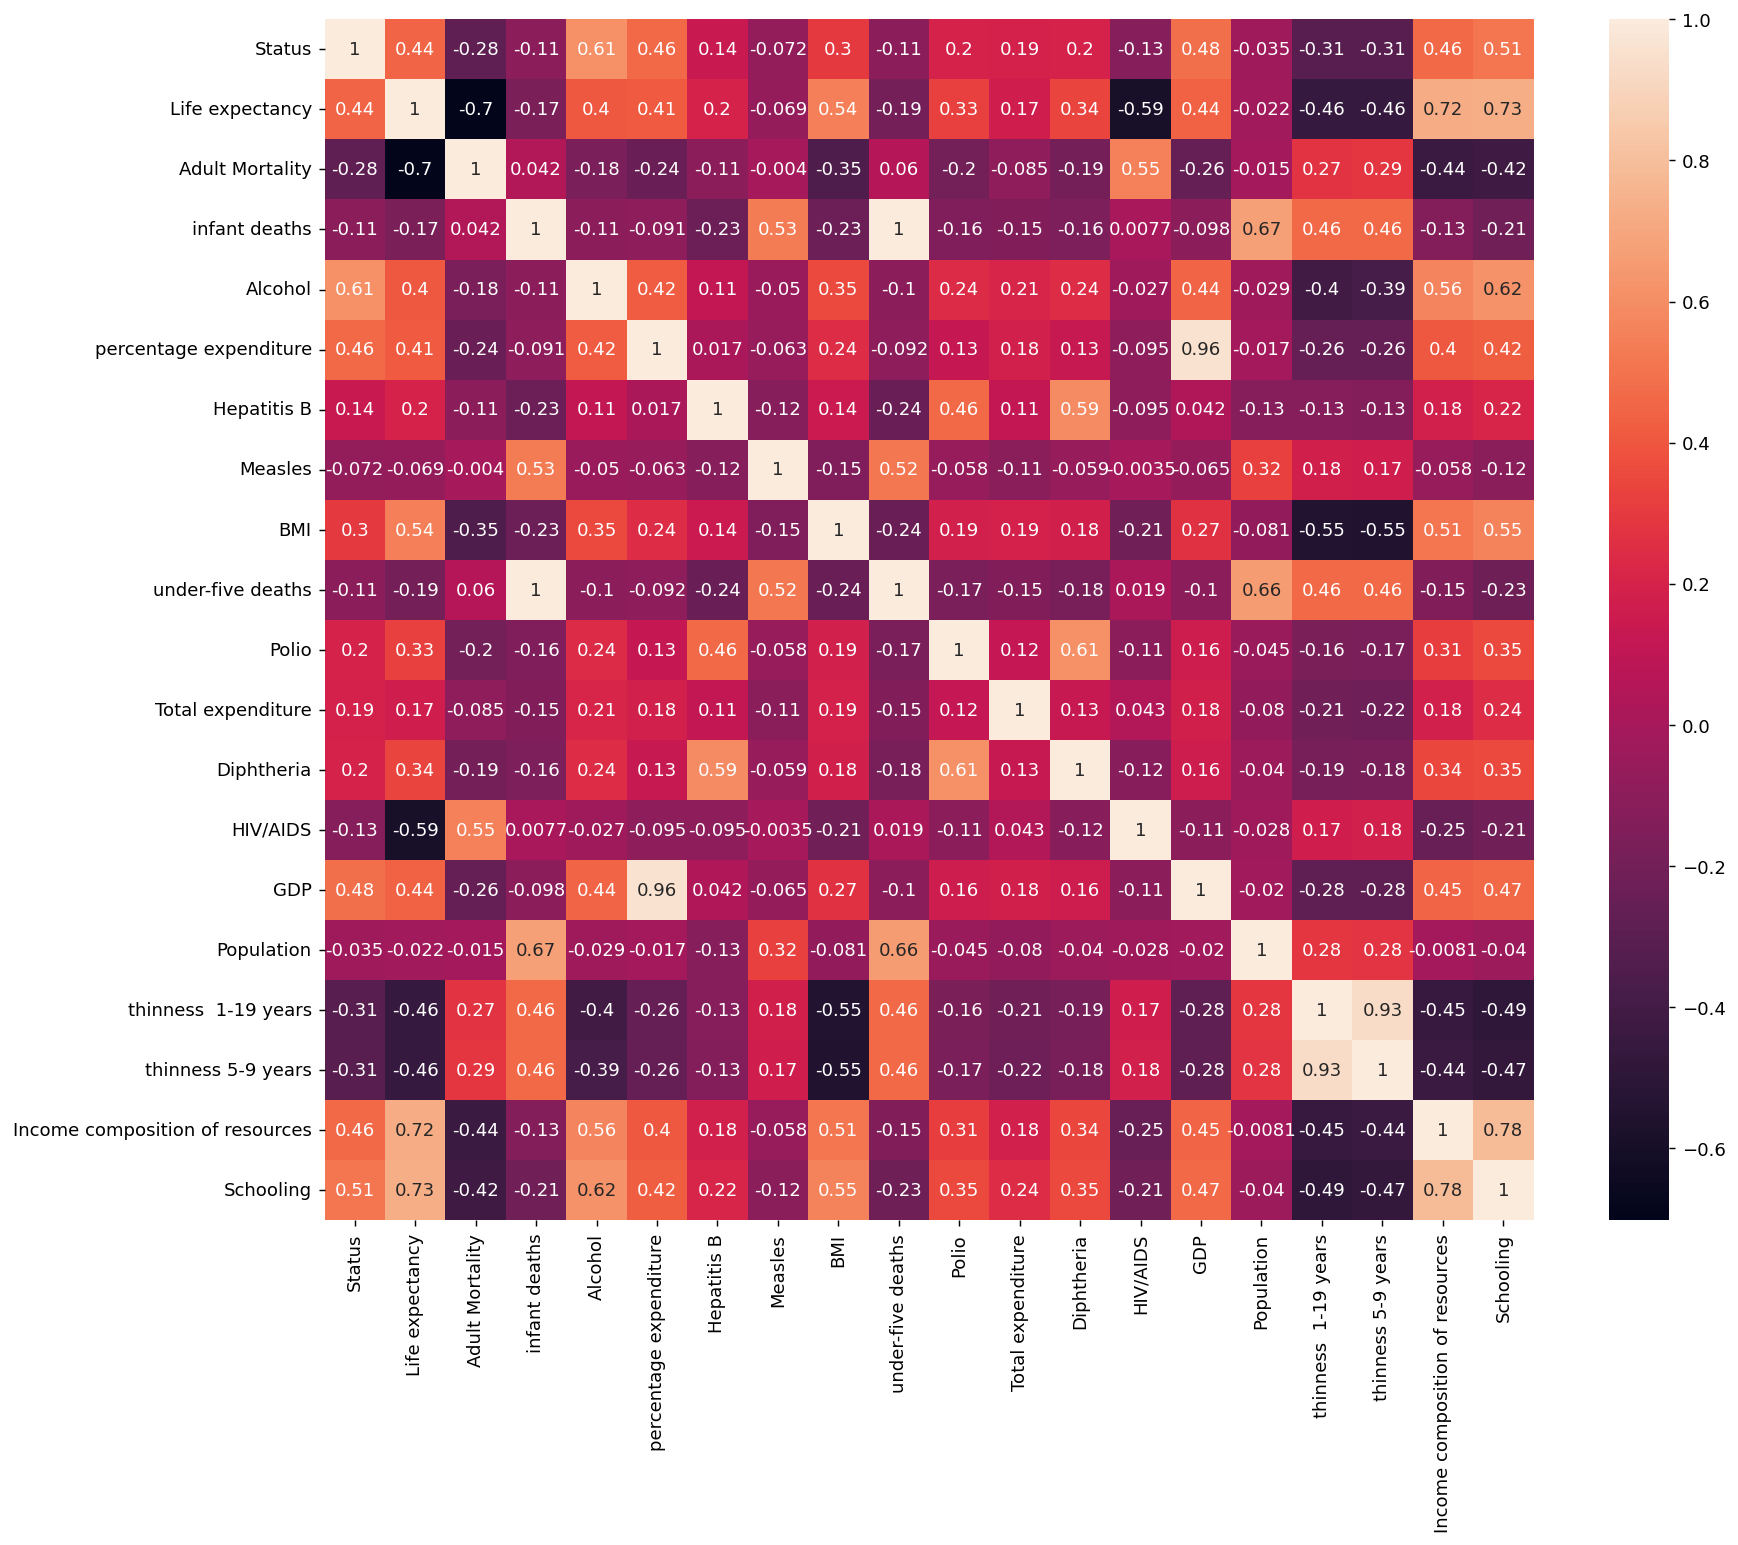

In [11]:
fig, ax = plt.subplots(figsize = (15,12), dpi=130)


heatmap(regression_df_wo_null[regression_df_wo_null.columns[2:]].corr(), annot=True, ax=ax)

**<h3>**Principal Component Analysis**</h3>**

In [ ]:
for column in regression_df_wo_null.columns[2:]:
    x = regression_df_wo_null[column]
    regression_df_wo_null[column] = (x-x.mean())/x.std(ddof=1)

regression_df_wo_null_features = regression_df_wo_null[regression_df_wo_null.columns[2:]]



pca = PCA(n_components = len(regression_df_wo_null_features.columns))
pca.fit(regression_df_wo_null_features)
sliced_regression_df_wo_null = pca.transform(regression_df_wo_null_features)



importance = np.abs(pca.components_) * pca.explained_variance_ratio_.reshape(-1, 1)
feature_importance = importance.sum(axis=0)

for col_name, importance in zip(regression_df.columns[2:], feature_importance):
    print(col_name, '-', importance)

Status - 0.19699322427835786
Life expectancy - 0.18855691788539425
Adult Mortality - 0.19624449716165662
infant deaths - 0.16494114754591244
Alcohol - 0.20486707088350192
percentage expenditure - 0.19701900284680665
Hepatitis B - 0.16712813971883445
Measles - 0.17713064270794332
BMI - 0.17782070970918795
under-five deaths - 0.16487076071707057
Polio - 0.1695702510682359
Total expenditure - 0.1374042618662436
Diphtheria - 0.16127733936491748
HIV/AIDS - 0.1826919059674301
GDP - 0.1996752925756833
Population - 0.1676294298385733
thinness  1-19 years - 0.20452615901037027
thinness 5-9 years - 0.20333164341659438
Income composition of resources - 0.18255649559758771
Schooling - 0.17570815848002164


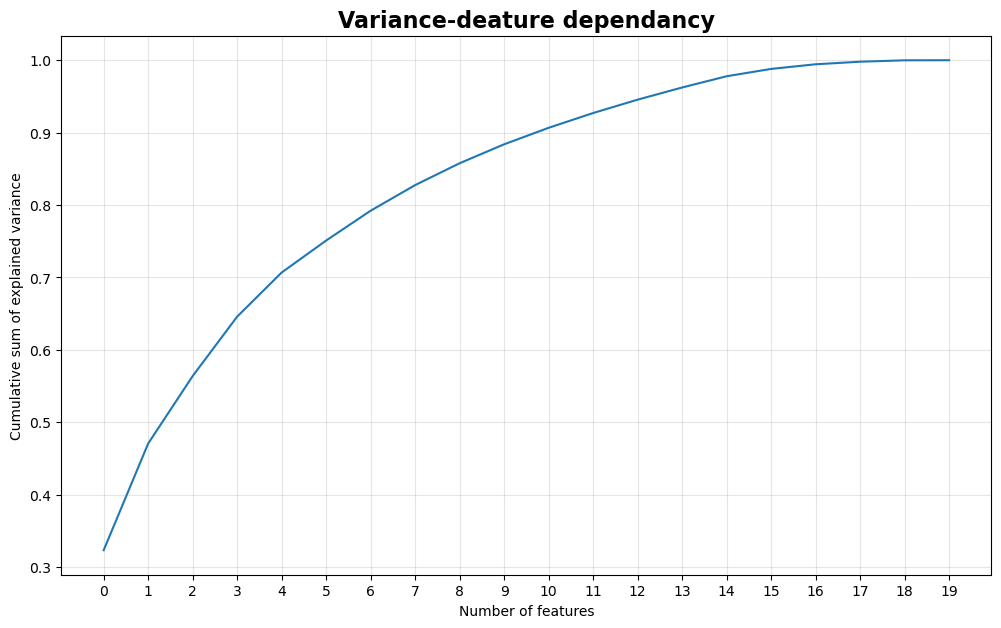

In [ ]:
cumsum_variance = np.cumsum(pca.explained_variance_ratio_)

plt.plot(cumsum_variance)
plt.grid(alpha=.33)
plt.xticks(np.arange(len(regression_df_wo_null_features.columns)))
plt.ylabel('Cumulative sum of explained variance')
plt.xlabel('Number of features')
plt.title('Variance-deature dependency', fontdict={'fontsize': 16, 'weight': 'bold'})
plt.show()

**<h3>**With the help of correlation matrix and PCA we can say that there are a couple of features that highly correlated with other features, which is not good from statistical point of view, so we're going to remove certain features from the dataset**</h3>**

**<h3>**We also saw that all the features contribte to the target variable relatively the same**</h3>**

**<h4>**I'll leave this problem of filling NA values for future as I've got some ideas, but do not have enough time**</h4>**



In [15]:
regression_df = regression_df.dropna().reset_index(drop=True)
regression_df = regression_df.drop(['Country', 'under-five deaths', 'percentage expenditure', 'thinness 5-9 years'], axis=1)
num_of_observations_per_year = regression_df.groupby('Year')['Life expectancy'].count()
num_of_observations_per_year

Year
2000     61
2001     66
2002     81
2003     95
2004    103
2005    110
2006    114
2007    120
2008    123
2009    126
2010    128
2011    130
2012    129
2013    130
2014    131
2015      2
Name: Life expectancy, dtype: int64

**<h3>**From the series above we can see that aftrer filtering out null data we have only certain years we can use for regression models because some of the years do not contain enough data**<h3>**

In [ ]:
relevant_years = num_of_observations_per_year[num_of_observations_per_year>100].index
regression_df = regression_df[regression_df['Year'].isin(relevant_years)]

regression_dfs_by_year = {year: df for year, df in regression_df.groupby('Year')}

In [ ]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.linear_model import LinearRegression

**<h4>**Creating a dictionary with countries as keys and dataframes' slices as values**<h4>**

In [28]:
tsa_dfs_by_country = {year: df for year, df in regression_df.groupby('Country')}

In [ ]:
countries_for_TSA = year_count_for_every_country[year_count_for_every_country.values>1].index
countries_for_TSA = list(countries_for_TSA)

time_series_df = df[df['Country'].isin(countries_for_TSA)]
df_per_country = {}

for country_for_TSA in countries_for_TSA:
    df_per_country[country_for_TSA] = time_series_df[time_series_df['Country']==country_for_TSA]



KeyError: 'Country'

**<h3>**Solving regression task**</h3>**

In [ ]:
df_per_year[2000]

,Year,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
0,2000,54.8,321.0,88,0.01,10.424960,62.0,6532,12.2,122,24.0,8.20,24.0,0.1,114.560000,293756.0,2.3,2.5,0.338,5.5
176,2000,74.5,92.0,0,2.15,167.727064,97.0,6,54.5,0,97.0,3.51,97.0,0.1,13636.346680,NaN,6.2,6.0,0.786,13.2
1058,2000,67.7,221.0,17,2.63,238.736981,NaN,0,4.4,21,8.0,5.25,81.0,0.2,1655.596261,1165743.0,1.6,1.6,0.539,8.2
2361,2000,65.8,235.0,0,0.71,4.249261,81.0,0,37.9,0,88.0,4.56,86.0,0.1,154.518572,41269.0,1.4,1.4,0.455,7.2
1042,2000,74.0,182.0,0,9.40,676.545388,NaN,0,37.7,0,97.0,6.62,97.0,0.1,5117.589923,NaN,4.3,4.2,0.000,14.1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
1877,2000,50.0,284.0,58,0.10,13.357838,NaN,21319,13.6,128,41.0,6.10,34.0,1.5,158.455972,11352973.0,12.8,12.9,0.253,2.8
96,2000,72.0,142.0,1,2.90,32.756269,55.0,15,47.1,1,96.0,6.25,93.0,0.1,622.742748,369588.0,2.1,2.2,0.639,11.2
2200,2000,72.0,18.0,0,3.00,21.254300,89.0,0,65.6,0,94.0,5.31,95.0,0.1,154.689230,17461.0,0.2,0.2,0.640,12.1
2151,2000,48.3,426.0,34,7.13,18.417918,NaN,2095,13.2,57,9.0,4.22,9.0,8.5,216.172747,82573.0,7.6,7.7,0.318,6.6


In [ ]:
df.isnull().sum()

Country                              0
Year                                 0
Status                               0
Life expectancy                     10
Adult Mortality                     10
infant deaths                        0
Alcohol                            194
percentage expenditure               0
Hepatitis B                        553
Measles                              0
BMI                                 34
under-five deaths                    0
Polio                               19
Total expenditure                  226
Diphtheria                          19
HIV/AIDS                             0
GDP                                448
Population                         652
thinness  1-19 years                34
thinness 5-9 years                  34
Income composition of resources    167
Schooling                          163
dtype: int64

**<h5>**We can see that some of the columns contain null values, thus let us analyze it throughly, so we can think about how we'll handle them**<h5>**

In [ ]:
print(df[df["Life expectancy"].isnull()==True]['Country'].value_counts()==df[df["Adult Mortality"].isnull()==True]['Country'].value_counts())
df[df["Life expectancy"].isnull()==True].index

Country
Cook Islands             True
Dominica                 True
Marshall Islands         True
Monaco                   True
Nauru                    True
Niue                     True
Palau                    True
Saint Kitts and Nevis    True
San Marino               True
Tuvalu                   True
Name: count, dtype: bool


Index([624, 769, 1650, 1715, 1812, 1909, 1958, 2167, 2216, 2713], dtype='int64')

**<h5>**We can see, that 'Life expectancy' and 'Adult Mortality' columns are absent in the same exact instances. 
As the data itself is just a dataset of time serieses 
we can with filling in missing values later via different techniques**<h5>**

In [ ]:
print(df[df["Alcohol"].isnull()==True]['Country'].value_counts(), "\n\n")
print("Sudan's instances length:",len(df[df['Country']=='Sudan']))

Country
South Sudan    16
Montenegro      2
Algeria         1
Paraguay        1
Niger           1
               ..
Ghana           1
Greece          1
Grenada         1
Guatemala       1
Zimbabwe        1
Name: count, Length: 178, dtype: int64 


Sudan's instances length: 16


**<h5>** Vice versa we can see that every instance with Sudan misses 

In [ ]:
sr = df.groupby('Country').agg("count")['Year'].sort_values(ascending=True)
sr[sr<16]

Country
Dominica                 1
Palau                    1
Nauru                    1
Tuvalu                   1
Cook Islands             1
Marshall Islands         1
Monaco                   1
Niue                     1
Saint Kitts and Nevis    1
San Marino               1
Name: Year, dtype: int64

<h4>Separating dataset into catergorial, numerical and target columns<h4>

In [ ]:
numerical_columns = df.columns[4:]
categorical_column = df.columns[[0,2]]
target_column = df.columns[3]

In [ ]:
df[:33]

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling,feature_vector
0,Afghanistan,2015,Developing,65.0,263.0,62,0.01,71.279624,65.0,1154,19.1,83,6.0,8.16,65.0,0.1,584.259210,33736494.0,17.2,17.3,0.479,10.1,"(263.0, 62.0, 0.01, 71.27962362, 65.0, 1154.0,..."
1,Afghanistan,2014,Developing,59.9,271.0,64,0.01,73.523582,62.0,492,18.6,86,58.0,8.18,62.0,0.1,612.696514,327582.0,17.5,17.5,0.476,10.0,"(271.0, 64.0, 0.01, 73.52358168, 62.0, 492.0, ..."
2,Afghanistan,2013,Developing,59.9,268.0,66,0.01,73.219243,64.0,430,18.1,89,62.0,8.13,64.0,0.1,631.744976,31731688.0,17.7,17.7,0.470,9.9,"(268.0, 66.0, 0.01, 73.21924272, 64.0, 430.0, ..."
3,Afghanistan,2012,Developing,59.5,272.0,69,0.01,78.184215,67.0,2787,17.6,93,67.0,8.52,67.0,0.1,669.959000,3696958.0,17.9,18.0,0.463,9.8,"(272.0, 69.0, 0.01, 78.1842153, 67.0, 2787.0, ..."
4,Afghanistan,2011,Developing,59.2,275.0,71,0.01,7.097109,68.0,3013,17.2,97,68.0,7.87,68.0,0.1,63.537231,2978599.0,18.2,18.2,0.454,9.5,"(275.0, 71.0, 0.01, 7.097108703, 68.0, 3013.0,..."
5,Afghanistan,2010,Developing,58.8,279.0,74,0.01,79.679367,66.0,1989,16.7,102,66.0,9.20,66.0,0.1,553.328940,2883167.0,18.4,18.4,0.448,9.2,"(279.0, 74.0, 0.01, 79.67936736, 66.0, 1989.0,..."
6,Afghanistan,2009,Developing,58.6,281.0,77,0.01,56.762217,63.0,2861,16.2,106,63.0,9.42,63.0,0.1,445.893298,284331.0,18.6,18.7,0.434,8.9,"(281.0, 77.0, 0.01, 56.76221682, 63.0, 2861.0,..."
7,Afghanistan,2008,Developing,58.1,287.0,80,0.03,25.873925,64.0,1599,15.7,110,64.0,8.33,64.0,0.1,373.361116,2729431.0,18.8,18.9,0.433,8.7,"(287.0, 80.0, 0.03, 25.87392536, 64.0, 1599.0,..."
8,Afghanistan,2007,Developing,57.5,295.0,82,0.02,10.910156,63.0,1141,15.2,113,63.0,6.73,63.0,0.1,369.835796,26616792.0,19.0,19.1,0.415,8.4,"(295.0, 82.0, 0.02, 10.91015598, 63.0, 1141.0,..."
9,Afghanistan,2006,Developing,57.3,295.0,84,0.03,17.171518,64.0,1990,14.7,116,58.0,7.43,58.0,0.1,272.563770,2589345.0,19.2,19.3,0.405,8.1,"(295.0, 84.0, 0.03, 17.17151751, 64.0, 1990.0,..."


<h4>Adding new column for analyzing similarity between instances in the dataset<h4>

In [ ]:
df["feature_vector"] = df[numerical_columns].apply(lambda row: tuple(row.fillna(0)), axis=1)


In [ ]:
instances_with_null_values = []

for row_num, row in df.isnull().iterrows():
    if True in row.values:
        instances_with_null_values.append(row_num)

instances_with_null_values[:5]

[32, 44, 45, 46, 47]

In [ ]:
row_for_row = {}

for row_num in instances_with_null_values:
    similarities = []
    for another_row in df.index[df.index!=row_num]:

        similarity = cos_similarity(df["feature_vector"][row_num], df["feature_vector"][another_row])
        similarities.append(similarity)
        # if similarity>list(max_similarity.values())[0]:
        #     max_similarity[another_row]=similarity
    row_for_row[row_num] = similarities

    

    

In [ ]:
row_for_row[32]

[0.9999999957061805,
 0.9999968383011708,
 0.999999996382998,
 0.9999997102613898,
 0.9999994809102606,
 0.9999997526089512,
 0.999947630933051,
 0.9999998213187202,
 0.9999999950524796,
 0.9999996972261084,
 0.999986486827737,
 0.9999999952828879,
 0.9999999330916233,
 0.9999999892386507,
 0.9999956333690923,
 0.9997521060409645,
 0.9906658496118139,
 0.9998749495537256,
 0.9998840539472279,
 0.567109934589705,
 0.9998872718082179,
 0.9999984820420758,
 0.9999991436761695,
 0.9999999973124633,
 0.9999076739146081,
 0.9999999936476013,
 0.9999995221213632,
 0.9999730681313963,
 0.9999997631451215,
 0.9226334785688679,
 0.9993163407721298,
 0.9993901660886915,
 0.99999999597962,
 0.9999999991323673,
 0.9999999988972617,
 0.9999999989367769,
 0.9999999997254561,
 0.9999995057773434,
 0.9999999957177614,
 0.9934657732921198,
 0.9999999996114116,
 0.9999999924349455,
 0.9999992599716315,
 0.9999887724169845,
 0.9999982200650267,
 0.9999999953055358,
 0.9999998912114283,
 0.9999992428798109

In [ ]:
df[df['infant deaths']==df['infant deaths'].max()]

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
1200,India,2001,Developing,62.9,222.0,1800,1.00,19.003406,NaN,51780,11.8,2400,58.0,4.50,59.0,0.3,447.138966,171477855.0,27.5,28.5,0.494,8.3
1201,India,2000,Developing,62.5,224.0,1800,0.93,19.266157,NaN,38835,11.4,2500,57.0,4.26,58.0,0.3,438.864634,1535912.0,27.7,28.6,0.489,8.3


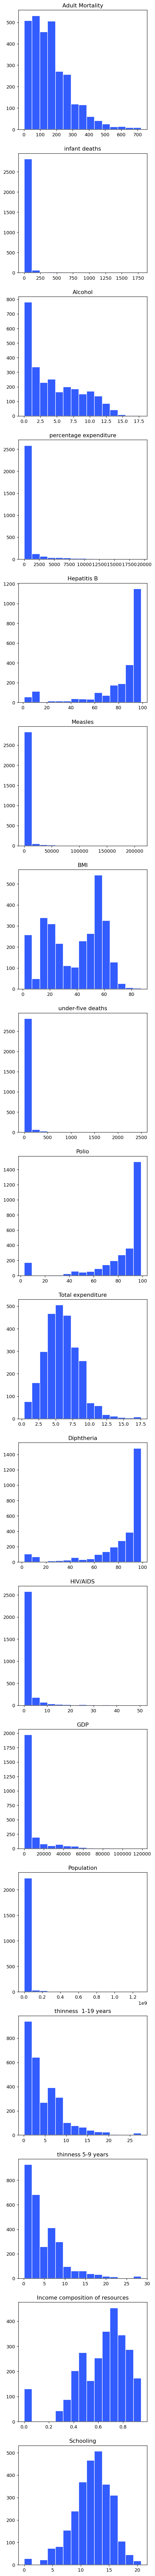

In [ ]:
fig, axes = plt.subplots(len(numerical_columns), figsize = (5, 100), dpi = 130)


for col_num, col_name in enumerate(numerical_columns):
    axes[col_num].hist(df[col_name], bins = 15, color = (0, 0.2, 1, 0.8), edgecolor='white')
    axes[col_num].set_title(f"{col_name}")

**USA BMI has false information, to be specific, in 2000 and 2001**

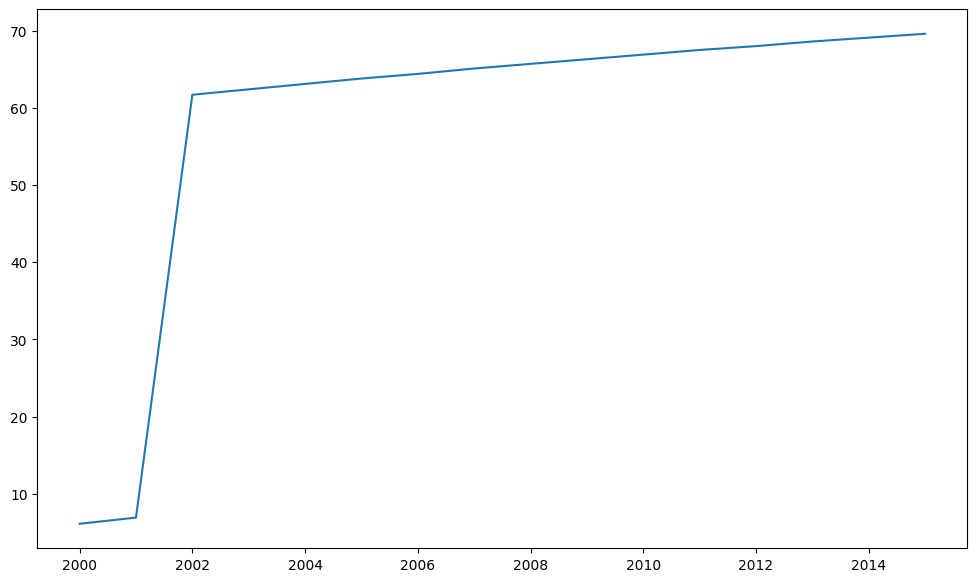

In [ ]:
year = df[df['Country']=='United States of America'].sort_values(by='Year', ascending=True)['Year']

bmi = df[df['Country']=='United States of America'].sort_values(by='Year', ascending=True)['BMI']


plt.plot(year, bmi)

In [ ]:
df.sort_values(by='BMI')

,Country,Year,Status,Life expectancy,Adult Mortality,infant deaths,Alcohol,percentage expenditure,Hepatitis B,Measles,BMI,under-five deaths,Polio,Total expenditure,Diphtheria,HIV/AIDS,GDP,Population,thinness 1-19 years,thinness 5-9 years,Income composition of resources,Schooling
2887,Viet Nam,2002,Developing,73.8,137.0,30,2.03,0.000000,NaN,6755,1.0,39,92.0,4.70,75.0,0.2,NaN,NaN,15.6,16.3,0.584,10.7
2886,Viet Nam,2003,Developing,74.0,137.0,30,2.19,0.000000,78.0,2297,1.4,37,96.0,4.84,99.0,0.2,NaN,NaN,15.6,16.2,0.592,10.9
207,Bangladesh,2000,Developing,65.3,173.0,231,0.01,3.696331,NaN,5098,1.4,316,83.0,2.33,82.0,0.1,45.633710,131581243.0,2.9,21.5,0.459,7.3
206,Bangladesh,2001,Developing,65.8,168.0,219,0.01,3.395070,NaN,4414,1.8,298,85.0,2.47,85.0,0.1,42.598115,1341716.0,2.7,21.3,0.468,7.5
2885,Viet Nam,2004,Developing,74.2,136.0,29,2.86,0.000000,94.0,217,1.9,36,96.0,5.90,96.0,0.2,NaN,NaN,15.4,16.1,0.601,11.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2468,Sudan,2004,Developing,59.7,278.0,68,1.59,37.044800,NaN,9562,NaN,102,74.0,3.39,74.0,0.2,565.569459,3186341.0,NaN,NaN,0.415,5.7
2469,Sudan,2003,Developing,59.6,278.0,69,1.74,35.352647,NaN,4381,NaN,104,69.0,3.18,69.0,0.2,477.738478,29435944.0,NaN,NaN,0.409,5.6
2470,Sudan,2002,Developing,59.4,277.0,70,1.59,30.622875,NaN,4529,NaN,106,6.0,2.95,6.0,0.2,412.151756,28679565.0,NaN,NaN,0.403,5.6
2471,Sudan,2001,Developing,58.9,283.0,71,1.81,28.880697,NaN,4362,NaN,108,66.0,2.96,66.0,0.2,377.525445,279455.0,NaN,NaN,0.399,5.6


In [ ]:
df.iloc[2471]['BMI']

nan

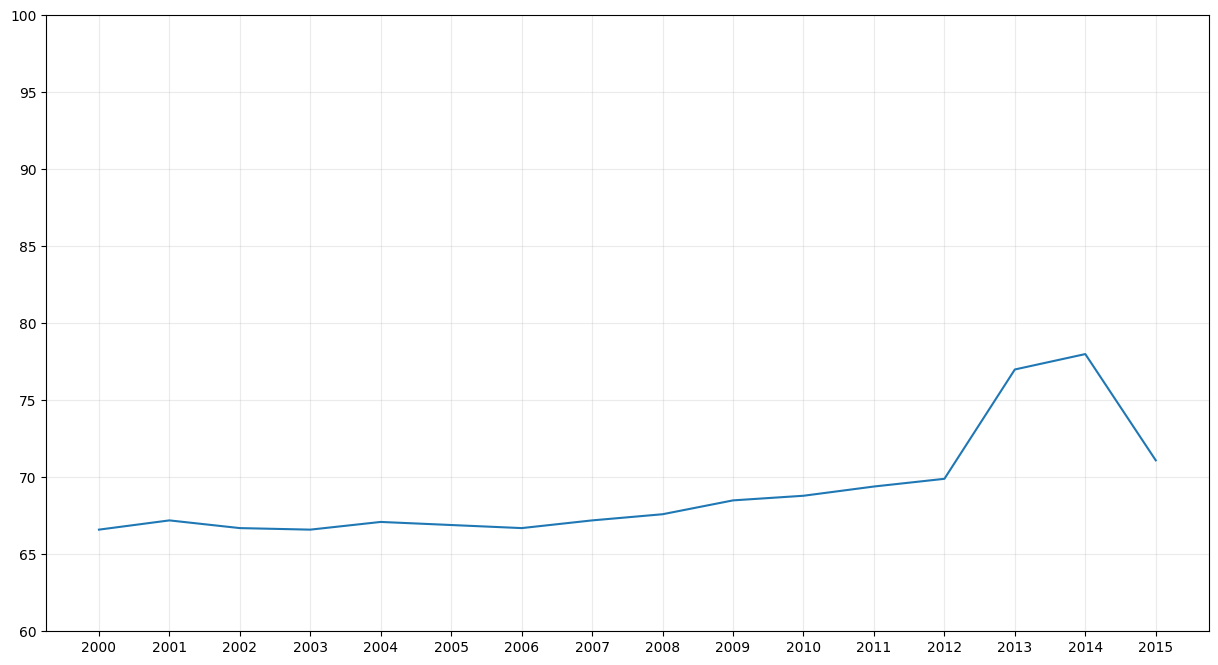

In [ ]:
fig, ax = plt.subplots(figsize = (15,8), dpi = 100)


ax.plot(
    df[df['Country']=='Kyrgyzstan']['Year'],
    df[df['Country']=='Kyrgyzstan']['Life expectancy']
    )
ax.grid(alpha=0.25)
ax.set_ylim([60, 100])
ax.set_xticks(np.arange(2000, 2016, 1))
plt.show()

<Axes: >

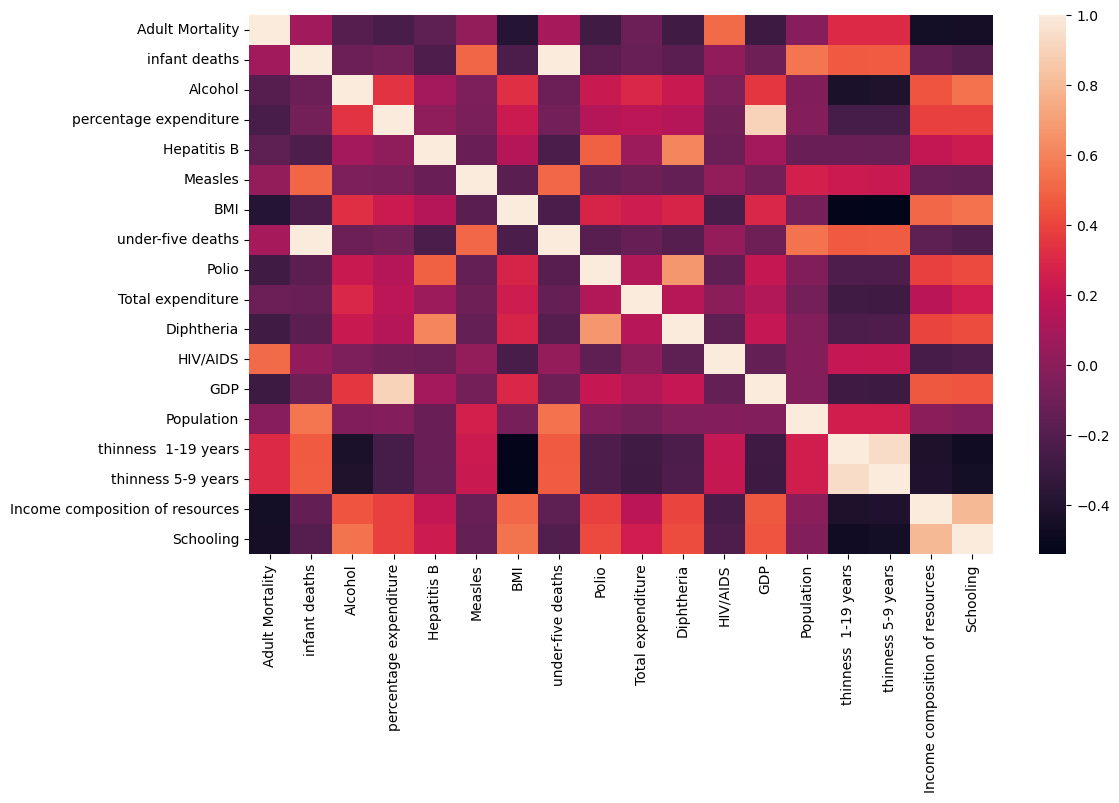

In [ ]:
heatmap(df[numerical_columns].corr())